<a href="https://colab.research.google.com/github/arminwitte/FoolsUNet/blob/main/foolsunet_all_inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!git clone https://github.com/arminwitte/FoolsUNet.git

fatal: destination path 'FoolsUNet' already exists and is not an empty directory.


In [14]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [15]:
from tensorflow.keras import layers

In [16]:
class SqueezeExcite(layers.Layer):
    """
    https://keras.io/examples/vision/patch_convnet/

    Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio,
            activation="relu",
            use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

In [17]:

class InverseResidualBlock(layers.Layer):
    """Implements an Inverse Residual Block like in MobileNetV2 and MobileNetV3

    https://stackoverflow.com/a/61334159

    Args:
        features: Number of features.
        expand_factor: factor by witch to expand number of layers
        strides: Stride used in last convolution.
        batch_norm: flag if Batch Normalisation should be used.

    Inputs:
        Convolutional features.

    Outputs:
        Modified feature maps.
    """

    def __init__(self, features=16, expand_factor=4, strides=1, batch_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.features = features
        self.expand_factor = expand_factor
        self.strides = strides
        self.batch_norm = batch_norm

    def get_config(self):
        config = super().get_config()
        config.update({"features": self.features,
                       "expand_factor": self.expand_factor,
                       "strides": self.strides,
                       "batch_norm": self.batch_norm, })
        return config

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.features*self.expand_factor, (1,1), strides=1)
        if self.batch_norm:
            self.bn1 = layers.BatchNormalization()
        self.activation1 = layers.Activation('relu6')
        self.dwise = layers.DepthwiseConv2D(3, padding='same', strides=self.strides)
        if self.batch_norm:
            self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation('relu6')
        self.squeeze_excite = SqueezeExcite(ratio=4)
        self.conv2 = layers.Conv2D(self.features, (1,1), strides=1, padding='same')
        if self.batch_norm:
            self.bn3 = layers.BatchNormalization()

    def call(self, x):
        shortcut = x
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.activation1(x)
        x = self.dwise(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.activation2(x)
        x = self.squeeze_excite(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn3(x)
        if (
            # stride check enforces that we don't add residuals when spatial
            # dimensions are None
            self.strides == 1 and
            # Depth matches
             x.get_shape().as_list()[3] == shortcut.get_shape().as_list()[3]
        ):
            x = tf.keras.layers.Add()([x, shortcut])

        return x

In [18]:
class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        filters = input_shape[1][-1]
        self.conv_g = layers.Conv2D(filters, 1, padding="same")
        self.bn_g = layers.BatchNormalization()

        self.conv_s = layers.Conv2D(filters, 1, padding="same")
        self.bn_s = layers.BatchNormalization()

        self.add = layers.Add()
        self.act_1 = layers.Activation("relu")
        self.conf_out = layers.Conv2D(1, 1, padding="same")
        self.act_2 = layers.Activation("sigmoid")
        self.mul = layers.Multiply()

    def call(self, x):
        g = x[0]
        s = x[1]

        g = self.conv_g(g)
        g = self.bn_g(g)

        s = self.conv_s(s)
        s = self.bn_s(s)

        out = self.add([g,s])
        out = self.act_1(out)
        out = self.conf_out(out)
        out = self.act_2(out)
        out = self.mul([out,x[1]])
        return out

    def get_config(self):
        config = super().get_config()
        return config

In [19]:

def mlp(x, hidden_units=[2048, 1024], dropout_rate=0.1):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class MLP(layers.Layer):
    def __init__(self,hidden_units=[128,64],dropout_rate=0.1,**kwargs):
        super().__init__(**kwargs)
        self.hidden_units = []
        for units in hidden_units:
            self.hidden_units.append(layers.Dense(units, activation=tf.keras.activations.gelu))
        self.dropout = layers.Dropout(dropout_rate)
    def get_config(self):
        config = super().get_config()
        return config


    def call(self,x):
        for units in self.hidden_units:
            x = units(x)
        x = self.dropout(x)
        return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.experimental.numpy.expand_dims(
            tf.experimental.numpy.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

class PatchAndEncode(layers.Layer):
    """https://blog.gopenai.com/understanding-vision-transformers-vit-with-tensorflow-and-keras-a-cifar-100-experiment-b820e08473f8"""
    def __init__(self, num_patches=64, patch_size=4, projection_dim=64):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim

    def build(self, input_shape):
        # patching the input image into patches
        self.patching = layers.Conv2D(self.projection_dim, kernel_size=self.patch_size, strides=self.patch_size)
        self.reshape = layers.Reshape((self.num_patches, self.projection_dim), name='pacthes')

        # Learnable positional embeddings
        self.lambda0 = layers.Lambda(lambda x: tf.expand_dims(tf.range(self.num_patches), axis=0))
        self.embedding = layers.Embedding(input_dim=self.num_patches, output_dim=self.projection_dim)

        # Add positional embeddings to patches
        self.add = layers.Add()


    def call(self, x):
        # patching the input image into patches
        patching = self.patching(x)
        patches = self.reshape(patching)

        # Learnable positional embeddings
        lmbd = self.lambda0(patches)
        position_embeddings = self.embedding(lmbd)

        # Add positional embeddings to patches
        patches = self.add([patches,position_embeddings])
        return patches


    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [20]:
class MakeShape(layers.Layer):
    def __init__(self, shape, **kwargs):
        super().__init__(**kwargs)
        self.shape = shape
    def build(self, input_shape):
        s = self.shape
        self.dense = layers.Dense(s[1]*s[2]*s[3]//input_shape[1])
        self.reshape = layers.Reshape(s[1:])

    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [21]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads=4, projection_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.projection_dim = projection_dim

    def get_config(self):
        config = super().get_config()
        config.update({"num_heads"})

    def build(self, input_shape):
        # Layer normalization 1.
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        # Create a multi-head attention layer.
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.projection_dim, dropout=0.1
        )
        # Skip connection 1.
        self.add1 = layers.Add()
        # Layer normalization 2.
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        # MLP.
        self.mlp = MLP(hidden_units=[self.projection_dim*2,self.projection_dim])
        # Skip connection 2.
        self.add2 = layers.Add()

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x)
        # Create a multi-head attention layer.
        attention_output = self.attention(x1, x1)
        # Skip connection 1.
        x2 = self.add1([attention_output, x])
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        encoded_patches = self.add2([x3, x2])
        return encoded_patches

## U-Net

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
model = Generator()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_15 (Sequential)  (None, 128, 128, 64)         3072      ['input_2[0][0]']             
                                                                                                  
 sequential_16 (Sequential)  (None, 64, 64, 128)          131584    ['sequential_15[0][0]']       
                                                                                                  
 sequential_17 (Sequential)  (None, 32, 32, 256)          525312    ['sequential_16[0][0]']       
                                                                                            

## New model

In [24]:
def downsample1(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential([InverseResidualBlock(filters),
InverseResidualBlock(filters),
InverseResidualBlock(filters, strides =2)])
  return result


def upsample1(filters, size, apply_dropout=False):


  result = tf.keras.Sequential([layers.UpSampling2D(size=2),
#layers.Conv2DTranspose(filters, size, strides=2,
#                                    padding='same,
#                                    use_bias=False),
#layers.BatchNormalization(),
#layers.ReLU(),
InverseResidualBlock(filters),
InverseResidualBlock(filters),])

  return result

def foolsunet(num_transformers=0):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  #initializer = tf.random_normal_initializer(0., 0.02)
  #first = tf.keras.layers.Conv2D(64, 3,
  #                                      strides=1,
  #                                      padding='same',
  #                                      kernel_initializer=initializer,
  #                                      activation='relu6')  # (batch_size, 256, 256, 3)


  down_stack = [
    InverseResidualBlock(24, strides=2),#downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    InverseResidualBlock(32, strides=2),#downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample1(48, 4),  # (batch_size, 32, 32, 256)
    downsample1(64, 4),  # (batch_size, 16, 16, 512)
    downsample1(96, 4),  # (batch_size, 8, 8, 512)
    #downsample1(128, 4),  # (batch_size, 4, 4, 512)
    #downsample1(192, 4),  # (batch_size, 2, 2, 512)
    #downsample1(512, 4),  # (batch_size, 1, 1, 512)
  ]

  transformers = []
  if num_transformers > 0:
    transformers.append(PatchAndEncode(num_patches=64, patch_size=4, projection_dim=128))

  for _ in range(num_transformers):
    transformers.append(TransformerBlock(num_heads=12, projection_dim=128))

  if num_transformers > 0:
    transformers.append(MakeShape([None,32,32,48]))

  up_stack = [
    #upsample1(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample1(128, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #upsample1(96, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample1(64, 4),  # (batch_size, 16, 16, 1024)
    upsample1(48, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  attention_stack = [Attention() for _ in range(len(down_stack)-1)]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer)  # (batch_size, 256, 256, 3)

  x = inputs
  #x = first(x)

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # bottleneck
  for t in transformers:
    x = t(x)

  # Upsampling and establishing the skip connections
  for up, skip, attention in zip(up_stack, skips, attention_stack):
    x = up(x)
    skip = attention([x, skip])
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
model = foolsunet(0)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 inverse_residual_block (In  (None, 128, 128, 24)         9144      ['input_3[0][0]']             
 verseResidualBlock)                                                                              
                                                                                                  
 inverse_residual_block_1 (  (None, 64, 64, 32)           17952     ['inverse_residual_block[0][0]
 InverseResidualBlock)                                              ']                            
                                                                                            

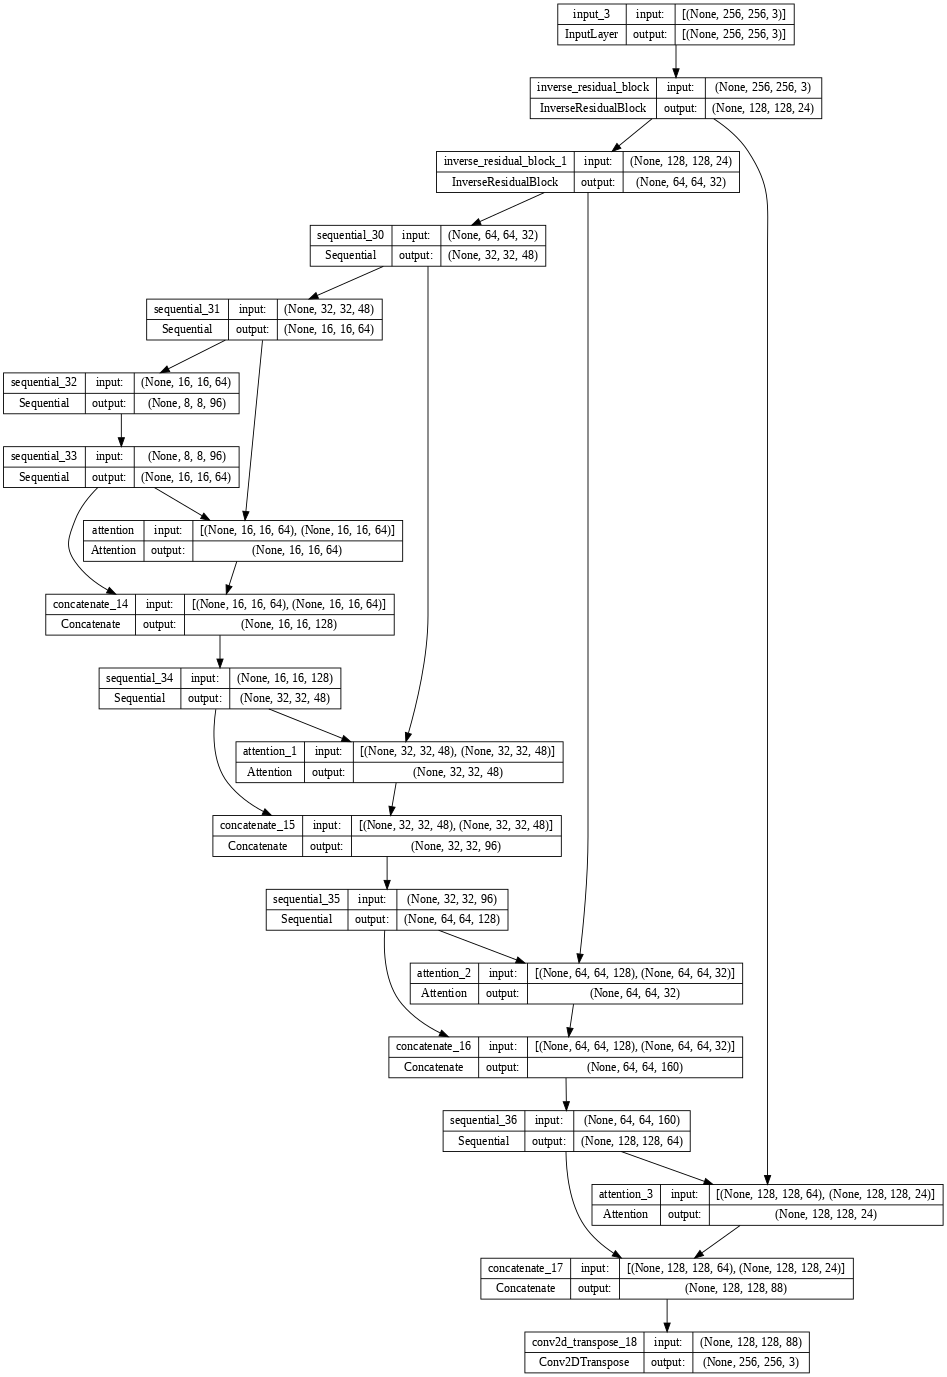

In [26]:

tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [27]:
import tensorflow_datasets as tfds

In [28]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXLVDDT/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXLVDDT/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [29]:

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [30]:

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (256, 256),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [31]:

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [32]:

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [34]:

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [35]:
model = foolsunet(0)
#model = Generator()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          #callbacks=[DisplayCallback()]
)

Epoch 1/20
57/57 [==============================] - 142s 1s/step - loss: 0.7389 - accuracy: 0.6939 - val_loss: 0.9790 - val_accuracy: 0.5732
Epoch 2/20
57/57 [==============================] - 70s 1s/step - loss: 0.5694 - accuracy: 0.7692 - val_loss: 0.9444 - val_accuracy: 0.5732
Epoch 3/20
57/57 [==============================] - 64s 1s/step - loss: 0.4791 - accuracy: 0.8101 - val_loss: 0.9803 - val_accuracy: 0.5732
Epoch 4/20
57/57 [==============================] - 62s 1s/step - loss: 0.4270 - accuracy: 0.8327 - val_loss: 1.0448 - val_accuracy: 0.5732
Epoch 5/20
57/57 [==============================] - 70s 1s/step - loss: 0.3892 - accuracy: 0.8472 - val_loss: 1.0786 - val_accuracy: 0.5741
Epoch 6/20
57/57 [==============================] - 65s 1s/step - loss: 0.3566 - accuracy: 0.8607 - val_loss: 1.1592 - val_accuracy: 0.4386
Epoch 7/20
57/57 [==============================] - 64s 1s/step - loss: 0.3345 - accuracy: 0.8691 - val_loss: 1.6666 - val_accuracy: 0.3388
Epoch 8/20
57/57 [=